# Neural Networks For Market Trading

In [2]:
import pandas as pd
df = pd.read_csv("USDJPY_Candlestick_1_D_ASK_05.05.2003-19.10.2019.csv")

#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()

,Local time,open,high,low,close,volume
4292,14.10.2019 00:00:00.000 GMT+0300,108.372,108.525,108.033,108.404,122267.0400
4293,15.10.2019 00:00:00.000 GMT+0300,108.408,108.901,108.157,108.868,161800.8200
4294,16.10.2019 00:00:00.000 GMT+0300,108.878,108.878,108.565,108.792,178244.1800
4295,17.10.2019 00:00:00.000 GMT+0300,108.793,108.941,108.454,108.692,234278.7681
4296,18.10.2019 00:00:00.000 GMT+0300,108.706,108.724,108.388,108.433,148743.3600


# Support and Resistance FUNCTIONS

In [3]:
def support(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.low[i]>df1.low[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.low[i]<df1.low[i-1]):
            return 0
    return 1

def resistance(df1, l, n1, n2): #n1 n2 before and after candle l
    for i in range(l-n1+1, l+1):
        if(df1.high[i]<df1.high[i-1]):
            return 0
    for i in range(l+1,l+n2+1):
        if(df1.high[i]>df1.high[i-1]):
            return 0
    return 1

In [4]:
length = len(df)
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
open = list(df['open'])
bodydiff = [0] * length

highdiff = [0] * length
lowdiff = [0] * length
ratio1 = [0] * length
ratio2 = [0] * length

def isEngulfing(l):
    row=l
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001      

    bodydiffmin = 0.002
    if (bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]<close[row-1] and
        open[row]>close[row] and 
        (open[row]-close[row-1])>=-0e-5 and close[row]<open[row-1]): #+0e-5 -5e-5
        return 1

    elif(bodydiff[row]>bodydiffmin and bodydiff[row-1]>bodydiffmin and
        open[row-1]>close[row-1] and
        open[row]<close[row] and 
        (open[row]-close[row-1])<=+0e-5 and close[row]>open[row-1]):#-0e-5 +5e-5
        return 2
    else:
        return 0
       
def isStar(l):
    bodydiffmin = 0.0020
    row=l
    highdiff[row] = high[row]-max(open[row],close[row])
    lowdiff[row] = min(open[row],close[row])-low[row]
    bodydiff[row] = abs(open[row]-close[row])
    if bodydiff[row]<0.000001:
        bodydiff[row]=0.000001
    ratio1[row] = highdiff[row]/bodydiff[row]
    ratio2[row] = lowdiff[row]/bodydiff[row]

    if (ratio1[row]>1 and lowdiff[row]<0.2*highdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]>close[row]):
        return 1
    elif (ratio2[row]>1 and highdiff[row]<0.2*lowdiff[row] and bodydiff[row]>bodydiffmin):# and open[row]<close[row]):
        return 2
    else:
        return 0
    
def closeResistance(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.high[l]-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c2 = abs(max(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.high[l])))<=lim
    c3 = min(df.open[l],df.close[l])<min(levels, key=lambda x:abs(x-df.high[l]))
    c4 = df.low[l]<min(levels, key=lambda x:abs(x-df.high[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0
    
def closeSupport(l,levels,lim):
    if len(levels)==0:
        return 0
    c1 = abs(df.low[l]-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c2 = abs(min(df.open[l],df.close[l])-min(levels, key=lambda x:abs(x-df.low[l])))<=lim
    c3 = max(df.open[l],df.close[l])>min(levels, key=lambda x:abs(x-df.low[l]))
    c4 = df.high[l]>min(levels, key=lambda x:abs(x-df.low[l]))
    if( (c1 or c2) and c3 and c4 ):
        return 1
    else:
        return 0

In [5]:
n1=2
n2=2
backCandles=30
signal = [0] * length

for row in range(backCandles, len(df)-n2):
    ss = []
    rr = []
    for subrow in range(row-backCandles+n1, row+1):
        if support(df, subrow, n1, n2):
            ss.append(df.low[subrow])
        if resistance(df, subrow, n1, n2):
            rr.append(df.high[subrow])
    #!!!! parameters
    if ((isEngulfing(row)==1 or isStar(row)==1) and closeResistance(row, rr, 150e-5) ):#and df.RSI[row]<30
        signal[row] = 1
    elif((isEngulfing(row)==2 or isStar(row)==2) and closeSupport(row, ss, 150e-5)):#and df.RSI[row]>70
        signal[row] = 2
    else:
        signal[row] = 0



In [6]:
df['signal']=signal

In [7]:
df[df['signal']==1].count()

Local time    48
open          48
high          48
low           48
close         48
volume        48
signal        48
dtype: int64

In [8]:
df.columns = ['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'signal']
#df=df.iloc[100:200]
df

,Local time,Open,High,Low,Close,Volume,signal
0,05.05.2003 00:00:00.000 GMT+0300,118.990,119.070,118.471,118.653,563551.1134,0
1,06.05.2003 00:00:00.000 GMT+0300,118.641,118.771,117.300,117.550,567318.3077,0
2,07.05.2003 00:00:00.000 GMT+0300,117.506,117.848,116.062,116.353,562770.3985,0
3,08.05.2003 00:00:00.000 GMT+0300,116.361,116.979,115.950,116.873,565066.5899,0
4,09.05.2003 00:00:00.000 GMT+0300,116.855,117.626,116.810,117.201,565239.7001,0
...,...,...,...,...,...,...,...
4292,14.10.2019 00:00:00.000 GMT+0300,108.372,108.525,108.033,108.404,122267.0400,0
4293,15.10.2019 00:00:00.000 GMT+0300,108.408,108.901,108.157,108.868,161800.8200,0
4294,16.10.2019 00:00:00.000 GMT+0300,108.878,108.878,108.565,108.792,178244.1800,0
4295,17.10.2019 00:00:00.000 GMT+0300,108.793,108.941,108.454,108.692,234278.7681,0


In [9]:
def SIGNAL():
    return df.signal

In [10]:
#A new strategy needs to extend Strategy class and override its two abstract methods: init() and next().
#Method init() is invoked before the strategy is run. Within it, one ideally precomputes in efficient, 
#vectorized manner whatever indicators and signals the strategy depends on.
#Method next() is then iteratively called by the Backtest instance, once for each data point (data frame row), 
#simulating the incremental availability of each new full candlestick bar.

#Note, backtesting.py cannot make decisions / trades within candlesticks — any new orders are executed on the
#next candle's open (or the current candle's close if trade_on_close=True). 
#If you find yourself wishing to trade within candlesticks (e.g. daytrading), you instead need to begin 
#with more fine-grained (e.g. hourly) data.

In [11]:
from backtesting import Strategy

class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next() 
        if self.signal1==2:
            sl1 = self.data.Close[-1] - 600e-4
            tp1 = self.data.Close[-1] + 450e-4
            self.buy(sl=sl1, tp=tp1)
        elif self.signal1==1:
            sl1 = self.data.Close[-1] + 600e-4
            tp1 = self.data.Close[-1] - 450e-4
            self.sell(sl=sl1, tp=tp1)

In [12]:
from backtesting import Backtest

bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)
stat = bt.run()
stat



C:\Users\Serkan POLAT\AppData\Local\Temp\ipykernel_10048\1132592598.py:3: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                    4296.0
Duration                               4296.0
Exposure Time [%]                    2.559926
Equity Final [$]                     9444.188
Equity Peak [$]                       10000.0
Return [%]                           -5.55812
Buy & Hold Return [%]               -8.613352
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                    -5.55812
Avg. Drawdown [%]                    -5.55812
Max. Drawdown Duration                 4263.0
Avg. Drawdown Duration                 4263.0
# Trades                                110.0
Win Rate [%]                         8.181818
Best Trade [%]                       0.057442
Worst Trade [%]                     -0.378445
Avg. Trade [%]                    

In [13]:
bt.plot()

Row(id='1455', ...)

In [14]:
#Target flexible way
pipdiff = 250*1e-4 #for TP
SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

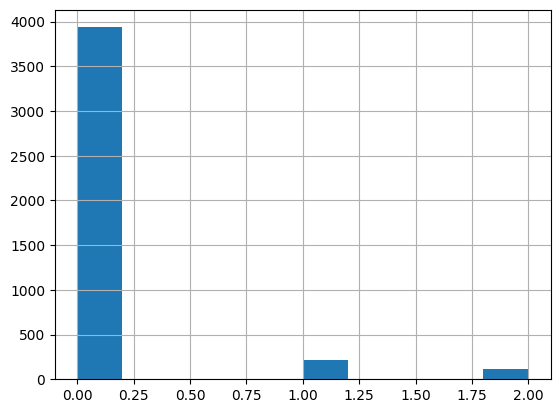

In [15]:
#!!! pitfall one category high frequency
df['Target'] = mytarget(30, df)
#df.tail(20)
#df['Target'] = df['Target'].astype(int)
df['Target'].hist()

In [16]:
import pandas_ta as pa
df["RSI"] = pa.rsi(df.Close, length=16)
df.tail(20)

,Local time,Open,High,Low,Close,Volume,signal,Target,RSI
4277,23.09.2019 00:00:00.000 GMT+0300,107.736,107.771,107.311,107.555,154022.7693,0,NaN,52.737125
4278,24.09.2019 00:00:00.000 GMT+0300,107.555,107.799,106.962,107.096,215279.3002,0,NaN,47.899883
4279,25.09.2019 00:00:00.000 GMT+0300,107.099,107.886,107.002,107.780,246974.1095,0,NaN,54.529430
4280,26.09.2019 00:00:00.000 GMT+0300,107.780,107.960,107.426,107.848,212912.0169,0,NaN,55.134821
4281,27.09.2019 00:00:00.000 GMT+0300,107.849,108.182,107.659,107.995,222541.0272,0,NaN,56.471170
4282,30.09.2019 00:00:00.000 GMT+0300,107.979,108.181,107.746,108.094,177440.6687,0,NaN,57.383053
4283,01.10.2019 00:00:00.000 GMT+0300,108.095,108.472,107.629,107.757,215975.8300,0,NaN,53.326746
4284,02.10.2019 00:00:00.000 GMT+0300,107.757,107.895,107.048,107.190,245226.7400,0,NaN,47.323257
4285,03.10.2019 00:00:00.000 GMT+0300,107.190,107.300,106.486,106.928,254161.2999,0,NaN,44.835394
4286,04.10.2019 00:00:00.000 GMT+0300,106.928,107.135,106.583,106.963,181875.1000,0,NaN,45.245566


In [17]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

              Open         High          Low        Close        Volume  \
count  4249.000000  4249.000000  4249.000000  4249.000000  4.249000e+03   
mean    104.100559   104.539829   103.599028   104.102086  4.862368e+05   
std      12.947733    12.964773    12.915856    12.949605  1.210865e+06   
min      75.652000    76.009000    75.584000    75.850000  1.500000e+00   
25%      95.755000    96.417000    94.945000    95.785000  1.225133e+05   
50%     107.673000   108.085000   107.200000   107.681000  2.222894e+05   
75%     113.453000   113.885000   112.932000   113.420000  5.941047e+05   
max     125.629000   125.859000   124.544000   125.661000  3.087527e+07   

            signal       Target          RSI  
count  4249.000000  4249.000000  4249.000000  
mean      0.040480     0.103554    50.156500  
std       0.260846     0.381553    11.428798  
min       0.000000     0.000000    18.246914  
25%       0.000000     0.000000    42.202113  
50%       0.000000     0.000000    49.2836

In [18]:
attributes = ['RSI', 'signal', 'Target']
df_model= df[attributes].copy()

df_model['signal'] = pd.Categorical(df_model['signal'])
dfDummies = pd.get_dummies(df_model['signal'], prefix = 'signalcategory')
df_model= df_model.drop(['signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,RSI,Target,signalcategory_0,signalcategory_1,signalcategory_2
0,41.947961,0.0,1,0,0
1,50.647668,0.0,1,0,0
2,48.361377,0.0,1,0,0
3,53.997282,0.0,1,0,0
4,49.775485,0.0,1,0,0
...,...,...,...,...,...
4244,48.197759,1.0,1,0,0
4245,46.756980,0.0,1,0,0
4246,46.133790,0.0,1,0,0
4247,44.044136,0.0,1,0,0


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 94.1157%
****Test Results****
Accuracy: 89.4118%


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)
#choices = [2, 0, -1, +1]
##choices = [2, 0, 3, +1]
print(model.get_booster().feature_names)

[[2769    1    0]
 [ 111   18    0]
 [  63    0   12]]
[[1139    7    5]
 [  86    1    0]
 [  36    1    0]]
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      2770
         1.0       0.95      0.14      0.24       129
         2.0       1.00      0.16      0.28        75

    accuracy                           0.94      2974
   macro avg       0.96      0.43      0.50      2974
weighted avg       0.94      0.94      0.92      2974

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      1151
         1.0       0.11      0.01      0.02        87
         2.0       0.00      0.00      0.00        37

    accuracy                           0.89      1275
   macro avg       0.34      0.33      0.32      1275
weighted avg       0.82      0.89      0.85      1275

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


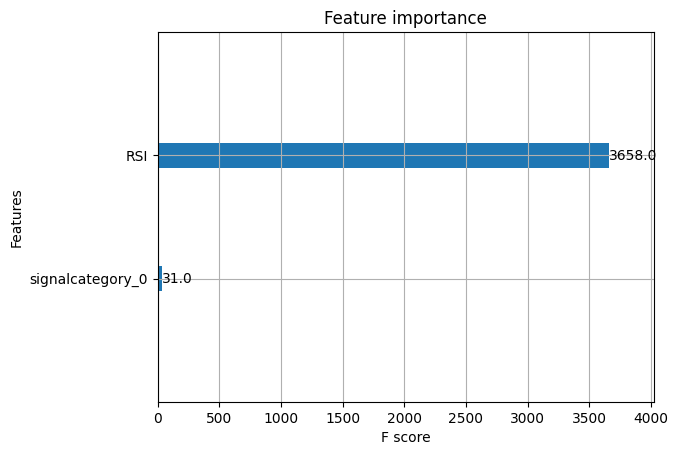

['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']


In [21]:
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
#plot feature importance
plot_importance(model)
pyplot.show()
print(model.get_booster().feature_names)

In [22]:
from sklearn.neural_network import MLPClassifier

attributes = ['RSI', 'signalcategory_0', 'signalcategory_1', 'signalcategory_2']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

NN = MLPClassifier(hidden_layer_sizes=(50, 50, 60, 30, 9), random_state=100, verbose=0, max_iter=1000, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test)) 

****Train Results****
Accuracy: 93.0169%
****Test Results****
Accuracy: 91.1765%


In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

[[2371    0    0]
 [ 117    0    0]
 [  61    0    0]]
[[1550    0    0]
 [  99    0    0]
 [  51    0    0]]
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      2371
         1.0       0.00      0.00      0.00       117
         2.0       0.00      0.00      0.00        61

    accuracy                           0.93      2549
   macro avg       0.31      0.33      0.32      2549
weighted avg       0.87      0.93      0.90      2549

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      1550
         1.0       0.00      0.00      0.00        99
         2.0       0.00      0.00      0.00        51

    accuracy                           0.91      1700
   macro avg       0.30      0.33      0.32      1700
weighted avg       0.83      0.91      0.87      1700



c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.